# ***1. Importing Necessary Libraries***



In [ ]:
!pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras for building the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


# ***2. Loading and Inspecting the Dataset***


In [ ]:
# loading the dataset to a pandas dataframe
diabetic_dataset = pd.read_csv('/content/diabetic_data.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
diabetic_dataset.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Verify the dimensions of the dataset
print("Dimensões do dataset:", diabetic_dataset.shape)

Dimensões do dataset: (101766, 50)


# ***3. Handling Missing Values***


## 3.1 Replacing '?' with NaN


In [ ]:
# Replace '?' with NaN
diabetic_dataset.replace('?', np.nan, inplace=True)

# Check for missing values
missing_values = diabetic_dataset.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


In [ ]:
# Calculate the percentage of missing values
missing_percent = diabetic_dataset.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(missing_percent[missing_percent > 0])


Percentage of missing values per column:
race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
max_glu_serum        94.746772
A1Cresult            83.277322
dtype: float64


## 3.2 Remove Columns with Many Missing Values


In [ ]:
# Remove columns with many missing values
diabetic_dataset.drop(columns=['weight', 'payer_code', 'medical_specialty'], inplace=True)

# Check dimensions after removal
print("\nDataset dimensions after removing columns with many missing values:", diabetic_dataset.shape)


Dataset dimensions after removing columns with many missing values: (101766, 47)


In [ ]:
# Impute missing values in 'max_glu_serum' and 'A1Cresult' with 'None'
diabetic_dataset['max_glu_serum'].fillna('None', inplace=True)
diabetic_dataset['A1Cresult'].fillna('None', inplace=True)

# Check counts after imputation
print("\nCounts in 'max_glu_serum' after imputation:")
print(diabetic_dataset['max_glu_serum'].value_counts())

print("\nCounts in 'A1Cresult' after imputation:")
print(diabetic_dataset['A1Cresult'].value_counts())


Counts in 'max_glu_serum' after imputation:
max_glu_serum
None    96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

Counts in 'A1Cresult' after imputation:
A1Cresult
None    84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64


## 3.3 Imputing Missing Values


In [ ]:
# Replace missing values with 'unknown' in columns 'diag_1', 'diag_2', and 'diag_3'
for col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_dataset[col].fillna('unknown', inplace=True)

# Check if there are still missing values
missing_values = diabetic_dataset.isnull().sum()
print("\nMissing values after imputation:")
print(missing_values[missing_values > 0])


Missing values after imputation:
race    2273
dtype: int64


In [ ]:
# Check missing values in 'race'
print("\nMissing values in 'race':", diabetic_dataset['race'].isnull().sum())

# Replace missing values in 'race' with 'unknown'
diabetic_dataset['race'].fillna('unknown', inplace=True)


Missing values in 'race': 2273


# ***4. Removing Duplicates and Irrelevant Columns***

In [ ]:
# Check if there are duplicates
has_duplicates = diabetic_dataset.duplicated().any()
print(f"\nAre there duplicates: {has_duplicates}")

# Remove irrelevant columns
diabetic_dataset.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

# Check dimensions after removal
print("Dimensões do dataset após remover colunas irrelevantes:", diabetic_dataset.shape)


Are there duplicates: False
Dimensões do dataset após remover colunas irrelevantes: (101766, 45)


# ***5. Mapping ICD-9 Codes***


In [ ]:
# Function to map ICD-9 codes
def map_icd9(code):
    code = str(code)
    if code == 'unknown':
        return 'unknown'
    elif code.startswith('V') or code.startswith('E'):
        return 'Supplementary Classification'
    else:
        try:
            code = float(code)
            if code >= 1 and code < 140:
                return 'Infectious and Parasitic Diseases'
            elif code >= 140 and code < 240:
                return 'Neoplasms'
            elif code >= 240 and code < 280:
                return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
            elif code >= 280 and code < 290:
                return 'Diseases of the Blood and Blood-forming Organs'
            elif code >= 290 and code < 320:
                return 'Mental Disorders'
            elif code >= 320 and code < 390:
                return 'Diseases of the Nervous System and Sense Organs'
            elif code >= 390 and code < 460:
                return 'Diseases of the Circulatory System'
            elif code >= 460 and code < 520:
                return 'Diseases of the Respiratory System'
            elif code >= 520 and code < 580:
                return 'Diseases of the Digestive System'
            elif code >= 580 and code < 630:
                return 'Diseases of the Genitourinary System'
            elif code >= 630 and code < 680:
                return 'Complications of Pregnancy, Childbirth, and the Puerperium'
            elif code >= 680 and code < 710:
                return 'Diseases of the Skin and Subcutaneous Tissue'
            elif code >= 710 and code < 740:
                return 'Diseases of the Musculoskeletal System and Connective Tissue'
            elif code >= 740 and code < 760:
                return 'Congenital Anomalies'
            elif code >= 760 and code < 780:
                return 'Certain Conditions Originating in the Perinatal Period'
            elif code >= 780 and code < 800:
                return 'Symptoms, Signs, and Ill-defined Conditions'
            elif code >= 800 and code < 1000:
                return 'Injury and Poisoning'
            else:
                return 'Other'
        except ValueError:
            return 'unknown'

# Apply the mapping to 'diag_1', 'diag_2', and 'diag_3'
for col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_dataset[col] = diabetic_dataset[col].apply(map_icd9)

# Check counts after mapping
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(f"\nCategory counts in {col}:")
    print(diabetic_dataset[col].value_counts())


Category counts in diag_1:
diag_1
Diseases of the Circulatory System                                       30336
Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders    11459
Diseases of the Respiratory System                                       10407
Diseases of the Digestive System                                          9208
Symptoms, Signs, and Ill-defined Conditions                               7636
Injury and Poisoning                                                      6974
Diseases of the Genitourinary System                                      5078
Diseases of the Musculoskeletal System and Connective Tissue              4957
Neoplasms                                                                 3433
Infectious and Parasitic Diseases                                         2768
Diseases of the Skin and Subcutaneous Tissue                              2530
Mental Disorders                                                          2262
Supplementary Cla

In [ ]:
# Check the number of columns and presence of any missing values
print("Dataset dimensions (rows, columns):", diabetic_dataset.shape)
missing_values = diabetic_dataset.isnull().sum()
print(missing_values[missing_values > 0])

Dataset dimensions (rows, columns): (101766, 45)
Series([], dtype: int64)


# ***6. Descriptive Statistics***


## 6.1 Distribution of the Target Variable



Distribution of 'readmitted':
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


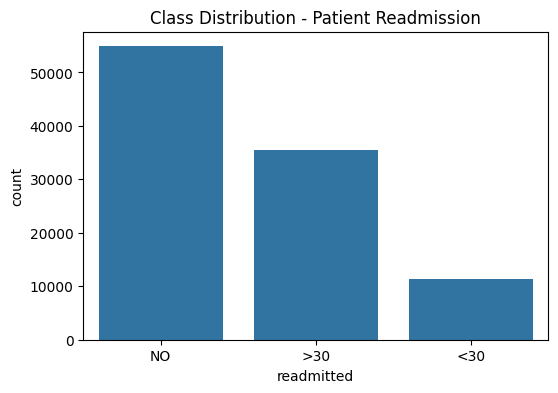

In [ ]:
# Check the distribution of the target variable 'readmitted'
print("\nDistribution of 'readmitted':")
print(diabetic_dataset['readmitted'].value_counts())

# Visualize the distribution
plt.figure(figsize=(6,4))
sns.countplot(x='readmitted', data=diabetic_dataset)
plt.title('Class Distribution - Patient Readmission')
plt.show()

## 6.2 Transforming the Target Variable



Distribution of 'readmitted' after transformation:
readmitted
0    90409
1    11357
Name: count, dtype: int64


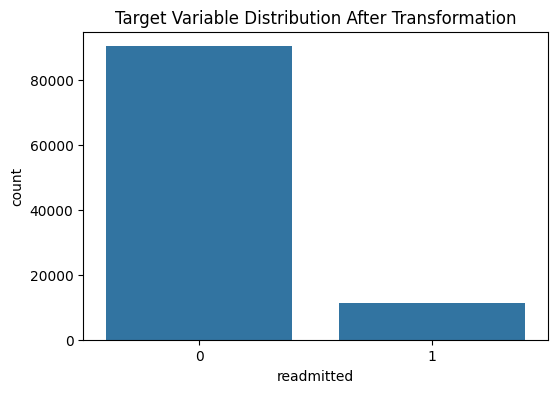

In [ ]:
# Transform 'readmitted' into 1 for readmissions in ≤30 days, 0 otherwise
diabetic_dataset['readmitted'] = diabetic_dataset['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})

# Check the distribution after transformation
print("\nDistribution of 'readmitted' after transformation:")
print(diabetic_dataset['readmitted'].value_counts())

# Visualize the new distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='readmitted', data=diabetic_dataset)
plt.title('Target Variable Distribution After Transformation')
plt.show()

Class distribution:
 readmitted
0    0.888401
1    0.111599
Name: proportion, dtype: float64
Class distribution:
 readmitted
0    90409
1    11357
Name: count, dtype: int64


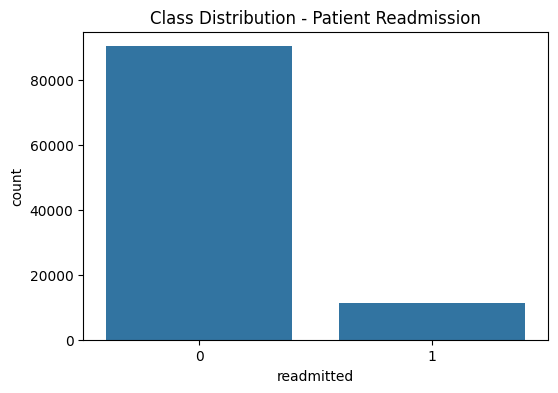

In [ ]:
# Check the distribution of labels
print("Class distribution:\n", diabetic_dataset['readmitted'].value_counts(normalize=True))

print("Class distribution:\n", diabetic_dataset['readmitted'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='readmitted', data=diabetic_dataset)
plt.title('Class Distribution - Patient Readmission')
plt.show()

# ***7. Encoding Categorical Variables***

## 7.1 Variable 'age'

Explanation:
Map the age intervals to numerical values representing the average age of each interval.
This allows the model to interpret age as a continuous numerical variable.


In [ ]:
# Map age intervals to numerical values (average age)
age_mapping = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}
diabetic_dataset['age'] = diabetic_dataset['age'].map(age_mapping)

# Check unique values in 'age' after mapping
print("\nUnique values in 'age' after mapping:")
print(diabetic_dataset['age'].unique())


Unique values in 'age' after mapping:
[ 5 15 25 35 45 55 65 75 85 95]


## 7.2 Nominal Categorical Variables

Explanation:
List the categorical columns to apply One-Hot Encoding.
Verify that all columns are present in the dataset.

In [ ]:
# List of categorical columns
categorical_cols = ['race', 'gender', 'max_glu_serum', 'A1Cresult',
                    'metformin', 'repaglinide', 'nateglinide',
                    'chlorpropamide', 'glimepiride', 'acetohexamide',
                    'glipizide', 'glyburide', 'tolbutamide',
                    'pioglitazone', 'rosiglitazone', 'acarbose',
                    'miglitol', 'troglitazone', 'tolazamide',
                    'examide', 'citoglipton', 'insulin',
                    'glyburide-metformin', 'glipizide-metformin',
                    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                    'metformin-pioglitazone', 'change', 'diabetesMed',
                    'diag_1', 'diag_2', 'diag_3',
                    'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

# Verify that all columns are present in the dataset
missing_cols = [col for col in categorical_cols if col not in diabetic_dataset.columns]
print("\nMissing categorical columns in the dataset:", missing_cols)


Missing categorical columns in the dataset: []


Explicação:

Aplicamos One-Hot Encoding nas colunas categóricas, usando drop_first=True para evitar a armadilha da multicolinearidade.
O dataset agora tem mais colunas devido às novas variáveis binárias criadas.


In [ ]:
# Apply One-Hot Encoding
diabetic_dataset = pd.get_dummies(diabetic_dataset, columns=categorical_cols, drop_first=True)

# Check dimensions after encoding
print("\nDataset dimensions after One-Hot Encoding:", diabetic_dataset.shape)


Dataset dimensions after One-Hot Encoding: (101766, 172)


# ***8. Balancing the Classes***

## 8.1 Checking the Class Distribution




In [ ]:
# Confirm that the positive class (1) represents about 11% of the data, indicating significant imbalance
class_distribution = diabetic_dataset['readmitted'].value_counts(normalize=True)
print("\nClass distribution after transformation:")
print(class_distribution)


Class distribution after transformation:
readmitted
0    0.888401
1    0.111599
Name: proportion, dtype: float64


## 8.2 Separating Features and Target


In [ ]:
# Separate features and target variable
X = diabetic_dataset.drop('readmitted', axis=1)
y = diabetic_dataset['readmitted']

## 8.3 Applying SMOTE for Balancing


In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new distribution
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
readmitted
0    90409
1    90409
Name: count, dtype: int64


# ***9. Splitting the Data into Training and Test Sets***




In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Check the dimensions of the sets
print("\nTraining set dimensions:", X_train.shape)
print("Test set dimensions:", X_test.shape)

# Display the shapes of the resampled sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set dimensions: (144654, 171)
Test set dimensions: (36164, 171)
Training set shape: (144654, 171) (144654,)
Testing set shape: (36164, 171) (36164,)


# ***10. Scaling Numerical Variables***

We use RobustScaler to scale numerical variables, making them less sensitive to outliers.
We fit on the training data and transform both training and test data.


In [ ]:
# Identify numerical columns
numerical_cols = ['age', 'time_in_hospital', 'num_lab_procedures',
                  'num_procedures', 'num_medications', 'number_outpatient',
                  'number_emergency', 'number_inpatient', 'number_diagnoses']

# Apply RobustScaler to numerical columns
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Check the scaled data
print("\nPreview of numerical columns after scaling:")
print(X_train[numerical_cols].head())


Preview of numerical columns after scaling:
        age  time_in_hospital  num_lab_procedures  num_procedures  \
169517  1.0              0.00               -1.12             0.0   
161073 -1.5             -0.75               -0.32             0.0   
64776   0.5              1.00                1.04             0.0   
10170  -2.0             -0.25                0.08             0.5   
166367  0.5              0.50               -0.16             0.5   

        num_medications  number_outpatient  number_emergency  \
169517         0.555556                0.0               0.0   
161073        -0.333333                0.0               0.0   
64776          1.555556                0.0               0.0   
10170         -0.777778                0.0               0.0   
166367        -0.333333                0.0               0.0   

        number_inpatient  number_diagnoses  
169517               1.0          0.333333  
161073               0.0         -1.666667  
64776               

In [ ]:
diabetic_dataset.head(5)

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_unknown,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,diag_1_Congenital Anomalies,diag_1_Diseases of the Blood and Blood-forming Organs,diag_1_Diseases of the Circulatory System,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Nervous System and Sense Organs,diag_1_Diseases of the Respiratory System,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",diag_1_Infectious and Parasitic Diseases,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_Supplementary Classification,"diag_1_Symptoms, Signs, and Ill-defined Conditions",diag_1_unknown,diag_2_Congenital Anomalies,diag_2_Diseases of the Blood and Blood-forming Organs,diag_2_Diseases of the Circulatory System,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Nervous System and Sense Organs,diag_2_Diseases of the Respiratory System,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",diag_2_Infectious and Parasitic Diseases,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_Supplementary Classification,"diag_2_Symptoms, Signs, and Ill-defined Conditions",diag_2_unknown,diag_3_Congenital Anomalies,diag_3_Diseases of the Blood and Blood-forming Organs,diag_3_Diseases of the Circulatory System,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Nervous System and Sense Organs,diag_3_Diseases of the Respiratory System,diag_3_Diseases of the Skin and Subcutaneous Tissue,"diag_3_Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",diag_3_Infectious and Parasitic Diseases,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Neoplasms,diag_3_Supplementary Classification,"diag_3_Symptoms, Signs, and Ill-defined Conditions",diag_3_unknown,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposit

In [ ]:
# Check the number of columns and presence of any missing values
print("Dataset dimensions (rows, columns):", diabetic_dataset.shape)
missing_values = diabetic_dataset.isnull().sum()
print(missing_values[missing_values > 0])

Dataset dimensions (rows, columns): (101766, 172)
Series([], dtype: int64)


# ***11. Training and Evaluating Multilayer Perceptron (MLP) Neural Network***


In [ ]:
# Normalizing the features for MLP (standard scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaling the training data
X_test_scaled = scaler.transform(X_test)  # Scaling the test data

In [ ]:
from tensorflow.keras.layers import Dropout

# Defining the MLP model with an extra hidden layer and dropout
mlp_model = Sequential()
mlp_model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.0001)))  # 1st hidden layer with L2
mlp_model.add(Dropout(0.5))  # Dropout to prevent overfitting
mlp_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))  # 2nd hidden layer with L2
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))  # 3rd hidden layer with L2
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


# Compiling the model
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mlp_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32,
                        validation_data=(X_test_scaled, y_test),
                        callbacks=[early_stopping])

Epoch 1/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8616 - loss: 0.3731 - val_accuracy: 0.9291 - val_loss: 0.2292
Epoch 2/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9270 - loss: 0.2362 - val_accuracy: 0.9297 - val_loss: 0.2222
Epoch 3/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9287 - loss: 0.2264 - val_accuracy: 0.9306 - val_loss: 0.2179
Epoch 4/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9289 - loss: 0.2245 - val_accuracy: 0.9299 - val_loss: 0.2166
Epoch 5/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9287 - loss: 0.2234 - val_accuracy: 0.9311 - val_loss: 0.2158
Epoch 6/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9308 - loss: 0.2192 - val_accuracy: 0.9313 - val_loss: 0.2141
Epoch 7/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9296 - loss: 0.2205 - val_accuracy: 0.9314 - val_loss: 0.2148
Epoch 8/30
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9306 - loss: 0

In [ ]:
# Displaying the final training and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")

Final Training Accuracy: 0.9313465356826782
Final Validation Accuracy: 0.9323083758354187
Final Training Loss: 0.20361997187137604
Final Validation Loss: 0.19882170855998993


In [ ]:
# Evaluate the model on the test set and display accuracy and loss
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test_scaled, y_test, verbose=0)

# Make predictions on the test set
y_pred_test = (mlp_model.predict(X_test_scaled) > 0.5).astype("int32")

# Calculate additional metrics
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Display all metrics together
print(f"MLP Neural Network Test Results:")
print(f"- Accuracy: {mlp_test_accuracy}")
print(f"- Loss: {mlp_test_loss}")
print(f"- Precision: {test_precision}")
print(f"- Recall: {test_recall}")
print(f"- F1-Score: {test_f1}")

1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
MLP Neural Network Test Results:
- Accuracy: 0.9317829608917236
- Loss: 0.19853408634662628
- Precision: 0.9983404608412587
- Recall: 0.86500387125318
- F1-Score: 0.926901537823343


## Plotting the training history


In [ ]:
# Evaluate the model on the test set
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test_scaled, y_test)

# Display the test accuracy
print(f"MLP Neural Network Test Accuracy: {mlp_test_accuracy}")


# Make predictions on the test set
y_pred_test = (mlp_model.predict(X_test_scaled) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Display the metrics
print(f"Test Set Metrics - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}")

1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9316 - loss: 0.1980
MLP Neural Network Test Accuracy: 0.9317829608917236
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Set Metrics - Accuracy: 0.9317829886074549, Precision: 0.9983404608412587, Recall: 0.86500387125318, F1-Score: 0.926901537823343


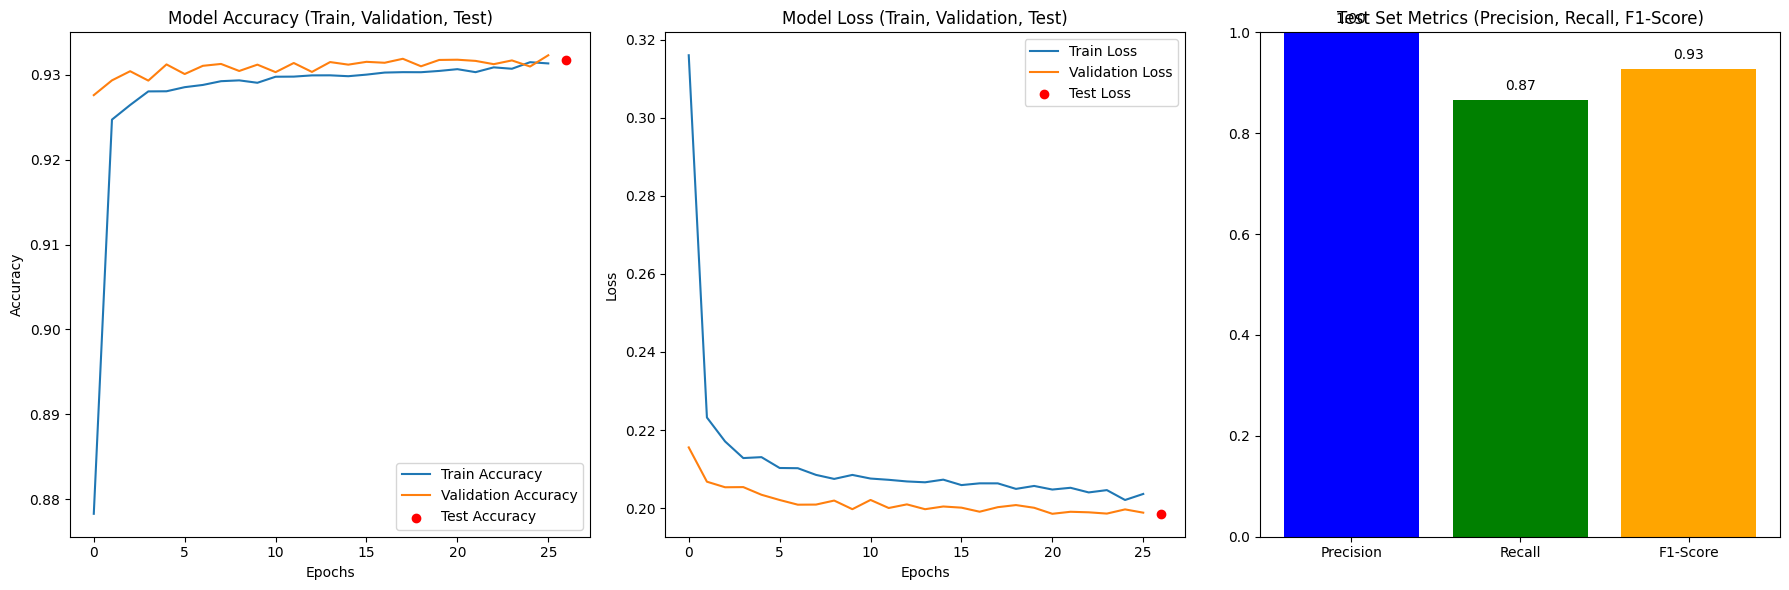

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Accuracy plot (Train, Validation, and Test)
plt.figure(figsize=(18, 6))

# Plot for Accuracy (Train, Validation, Test)
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.scatter([len(history.history['accuracy'])], [mlp_accuracy], label='Test Accuracy', color='red')  # Test accuracy
plt.title('Model Accuracy (Train, Validation, Test)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Step 2: Loss plot (Train, Validation, and Test)
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
plt.scatter([len(history.history['loss'])], [mlp_test_loss], label='Test Loss', color='red')  # Test loss
plt.title('Model Loss (Train, Validation, Test)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Step 3: Precision, Recall, and F1-Score for Test
plt.subplot(1, 3, 3)
metrics_labels = ['Precision', 'Recall', 'F1-Score']
metrics_values = [mlp_precision, mlp_recall, mlp_f1]

# Plotting the precision, recall, and F1-Score for the test set
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'orange'])
plt.title('Test Set Metrics (Precision, Recall, F1-Score)')
plt.ylim(0, 1)  # Set the y-axis limit to visualize the metrics between 0 and 1
for i, value in enumerate(metrics_values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')  # Add value labels on top of each bar

plt.tight_layout()
plt.show()